In [74]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [75]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [76]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [77]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [78]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [79]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [80]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [81]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [94]:
# Get a list of tables
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [95]:
# Get a list of column names and types for measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [96]:
# Get a list of column names and types for station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [86]:
# Find the most recent date in the data set.
query_latest_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
query_latest_date

('2017-08-23',)

Text(0, 0.5, 'Inches')

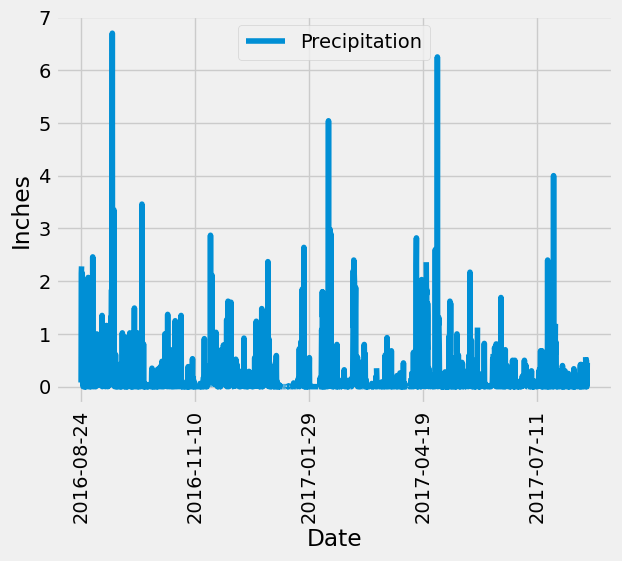

In [87]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
str_latest_date = query_latest_date[0]
latest_date = dt.datetime.strptime(str_latest_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
earliest_date = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurements.date, 
                        Measurements.prcp).\
                  filter(Measurements.date >= earliest_date).filter(Measurements.date <= latest_date).\
                  order_by(Measurements.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Set date as an index
df.sort_index(inplace=True)

# Sort the dataframe by date
df.set_index(df['Date'], inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xticks(rotation = 90)
plt.ylabel('Inches')

In [88]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [89]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(func.count(Stations.station)).all()
number_of_stations

[(9,)]

In [90]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurements.station, func.count(Measurements.id)).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.id).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [91]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_descrip = session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)).\
    filter(Measurements.station == 'USC00519281').all()
station_descrip

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

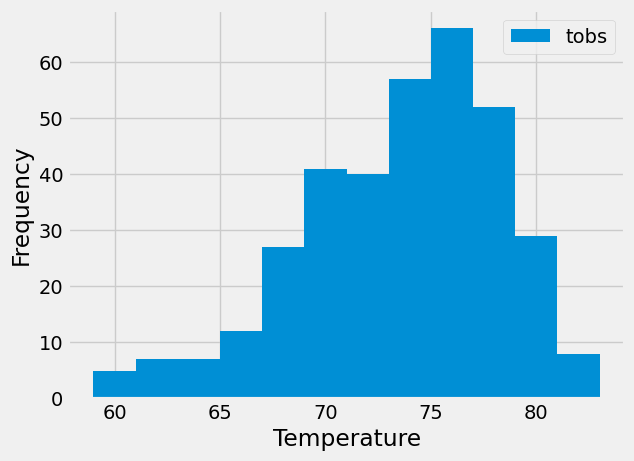

In [92]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_tob = session.query(Measurements.tobs).\
    filter(Measurements.station == 'USC00519281').\
    filter(Measurements.date >= earliest_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(station_tob, columns=['tobs'])

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.hist(bins=12)
plt.xlabel('Temperature')

# Close Session

In [93]:
# Close Session
session.close()